# PDE Modelling for convenience, do not save

## Objectives 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


In [3]:
# imports
from __future__ import division, print_function

import itertools as itt

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext memory_profiler
%load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [216]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(1,3, figsize=(10,7))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot pulser synthase densities
    ax = axs[2]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,w//2:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
    fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



In [278]:
import importlib
import omnisim as oms
oms = importlib.reload(oms)

# Params :    ,Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([0,    8e-3, 8e-3, 15,  3e-2,  1, 3e-2, 8e-2, 5e2, 2e2, 
#xr,   hS,   kS,  hR, kR,  hC,  kC,    pa,  colthresh   od0
1.2e3, 3.2, 100, 2.3, 55, 3.2, 2.7e3, 5e-3, 1e-3, 0.1], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,col_thresh,od0 = p0

simmer = oms.Simulator()
simmer.set_scale(16)
simmer.t_eval = np.arange(0,18*60,5)
species, nh, nw, _ = simmer.dims
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
scale = simmer.scale
# Setup initial conditions
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')# + 1e-7
initial_array[n_i,:,:] = 100
initial_array[cs_i,scale:-scale,scale:2*scale] = od0
initial_array[cs_i,:,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/4)
initial_array[cp_i,scale:-scale,2*scale:-scale] = od0
initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/4)

simmer.initial_array = initial_array
simmer.sim(p0)
im_arr = simmer.sim_arr
t_vec = simmer.sim_tvc
# anim = write_movie(im_arr, t_vec)
# print('random initial')

/home/jmp/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


In [279]:
anim = write_movie(im_arr, t_vec)
HTML(anim.to_html5_video())

In [280]:
simmer.out

  message: 'Required step size is less than spacing between numbers.'
     nfev: 209894
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225])
 t_events: None
        y: array([[1.11948731e-10, 1.16477189e-10, 1.21188828e-10, ...,
        6.15622197e-10, 6.40492133e-10, 6.66364344e-10],
       [4.06894354e-10, 4.23353709e-10, 4.40478865e-10, ...,
        2.23756312e-09, 2.32795573e-09, 2.42199117e-09],
       [1.13689178e-09, 1.18288039e-09, 1.23072929e-09, ...,
        6.25186857e-09, 6.50442707e-09, 6.76716335e-09],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ..

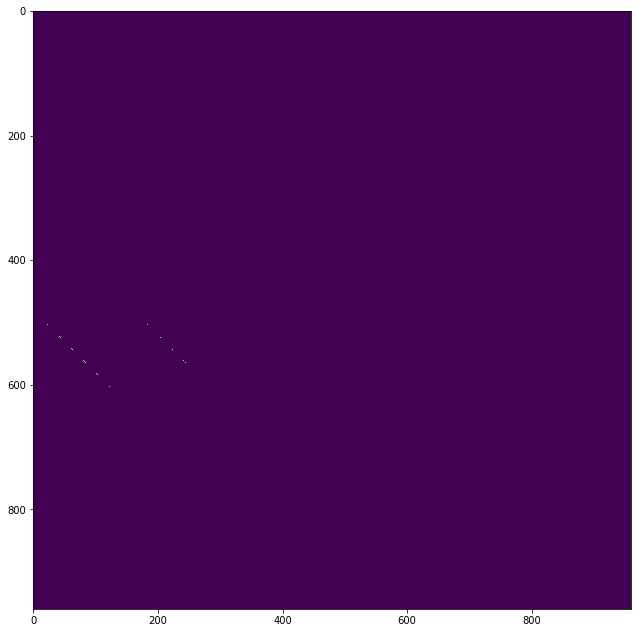

In [213]:
y = im_arr[10,:,:,:]
# y.shape = (species, nh, nw)
dy = np.zeros_like(y)
diff_terms = np.zeros_like(y)
nut_avail = np.zeros_like(y[0,:,:])
oms.calc_f(y, dy, diff_terms, nut_avail, simmer.params)
# dy[s_i,:,:].max()
# plt.imshow(y[s_i,:,:])
plt.figure(figsize=(11,11))
jac_arr = simmer.jacobian.calc_jac_wrapper(0,y.flatten()).toarray()
plt.imshow(np.abs(jac_arr))

In [179]:
y = initial_array
jac = simmer.jacobian.calc_jac_wrapper(0,y)
# i suppose use numpy's check_grad utility against the jacobian
bads = []
goods = []
species, nh, nw, _ = simmer.dims
for i in np.arange(species*nh*nw):
    f_lam = lambda y0 : simmer.f_ivp_wrapper(0,y0)[i]
    g_lam = lambda y0 : simmer.jacobian.calc_jac_wrapper(0,y0).toarray()[i,:]
#     err = opt.check_grad(f_lam, g_lam, y)
    err = opt.approx_fprime(y, f_lam,1e-8) - g_lam(y)
    bad_dus = np.arange(len(err))[err>1e-7]
    if np.all(np.isclose(0,err)):
        goods.append(i)
    else:
        for bad_du in bad_dus:
            u = bad_du // (nw*nh)
            bads.append((i//(nw*nh),u))

In [180]:
print(bads)

[]


In [89]:
i = 4
f_lam = lambda y0 : simmer.f_ivp_wrapper(0,y0)[i]
g_lam = lambda y0 : simmer.jacobian.calc_jac_wrapper(0,y0).toarray()[i,:]
err = opt.approx_fprime(y, f_lam,1e-7) - g_lam(y)

In [90]:
err[err>1e-4]

array([], dtype=float64)

In [287]:
from .solvers import impexp_cnmg_rk as cnmg_rk
cnmg_rk = importlib.reload(cnmg_rk)

ImportError: attempted relative import with no known parent package

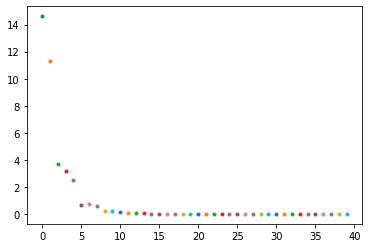

In [270]:
A = np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = np.array([[2,21,-12,-6]]).T.astype(np.float)
x_true = linalg.solve(A,b)
x = np.zeros_like(b)
for i in np.arange(40):
    x = cnmg_rk.gauss_seidel(A, b, x, n_iter=1, w=0.5)
    plt.plot(i, linalg.norm(A.dot(x)-b),'.')

In [271]:
linalg.norm(A.dot(x)-b)

0.00018083529313698166

In [273]:
from scipy import linalg
linalg.solve(A,b) - x

array([[5.17472830e-05],
       [1.09400504e-06],
       [9.89389952e-06],
       [8.28803597e-06]])